In [1]:
%matplotlib inline

from time import time

from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.datasets import mnist
from keras.layers import Input, Flatten, Dense, Activation, Conv2D, MaxPool2D
from keras.models import Model
from keras.optimizers import SGD
from keras.preprocessing.image import img_to_array, load_img
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np


TIMESTAMP = int(time())

/home/ettore/py3-venv/lib64/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Dados

Carregamos os dados já embaralhados divididos em train e test

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

Passamos as entradas pra `float` (pra poder manipular), adicionamos a dimensão do canal e pré-tratamos
Como temos um intervalo definido de entrada [0, 255], simplesmente mudamos a escala para [0, 1], o que é bem comum de se fazer em imagens


In [3]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

x_train /= 255
x_test /= 255

Passamos os labels pra one-hot encoding (vetor 10-dimensional)

In [4]:
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

## Modelo

Camada de entrada (compatível com a forma de x)

In [5]:
out = entry = Input(shape=x_train.shape[1:])

Camada de convolução

In [6]:
out = Conv2D(32, kernel_size=3, strides=1)(out)
out = Activation('relu')(out)
out = MaxPool2D()(out)

Transformamos o tensor em um vetor unidimensional. Isso  é necessário para podermos aplicar uma camada densa

In [7]:
out = Flatten()(out)

Camada intermediária

In [8]:
out = Dense(20)(out)
out = Activation('relu')(out)

Camada de saída com 10 neurônios, cada um responsável por um dígito e aplicação do softmax para obtermos uma distribuição de probabilidade

In [9]:
out = Dense(10)(out)
out = Activation('softmax')(out)

Definição do modelo em si

In [10]:
net = Model(entry, out)

Imprimimos a descrição do modelo

In [11]:
net.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
activation_1 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 5408)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                108180    
_________________________________________________________________
activation_2 (Activation)    (None, 20)                0         
__________

## Treinamento

Definição do custo e da otimização
Custo é a cross-entropia entre saída e resposta
Otimização é a descida de gradientes estocástica

In [12]:
net.compile(
    loss='categorical_crossentropy',
    optimizer=SGD(lr=0.01, momentum=0.9, nesterov=True),
    metrics=['accuracy'])

Treinamento em si

In [14]:
net.fit(
    x_train, y_train,
    batch_size=60,
    epochs=20,
    validation_data=(x_test, y_test),
    callbacks=[
        ModelCheckpoint('save/mnist.{epoch:02d}.h5'),
        TensorBoard(log_dir='logs/mnist_{}'.format(TIMESTAMP), histogram_freq=1)])

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 28s 460us/step - loss: 0.1501 - acc: 0.9553 - val_loss: 0.1114 - val_acc: 0.9661
Epoch 2/20
60000/60000 [==============================] - 27s 457us/step - loss: 0.0956 - acc: 0.9724 - val_loss: 0.0875 - val_acc: 0.9742
Epoch 3/20
60000/60000 [==============================] - 27s 448us/step - loss: 0.0735 - acc: 0.9780 - val_loss: 0.0749 - val_acc: 0.9763
Epoch 4/20
60000/60000 [==============================] - 27s 450us/step - loss: 0.0605 - acc: 0.9821 - val_loss: 0.0606 - val_acc: 0.9801
Epoch 5/20
60000/60000 [==============================] - 25s 418us/step - loss: 0.0521 - acc: 0.9842 - val_loss: 0.0573 - val_acc: 0.9824
Epoch 6/20
60000/60000 [==============================] - 26s 437us/step - loss: 0.0447 - acc: 0.9868 - val_loss: 0.0558 - val_acc: 0.9809
Epoch 7/20
60000/60000 [==============================] - 26s 439us/step - loss: 0.0404 - acc: 0.9873 - val_loss: 0.

## Inferência

In [40]:
i = np.random.choice(len(x_test))
image, answer = x_test[i], y_test[i]

Cria a entrada e infere a saída

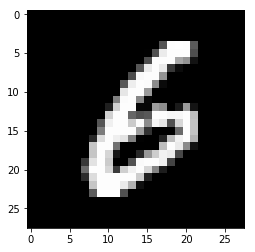

A rede diz 6
Gabarito 6


In [41]:
x = np.reshape(image, (1, 28, 28, 1))
y = net.predict(x, verbose=0)[0]

plt.imshow(x[0, ..., 0], cmap='gray')
plt.show()
print('A rede diz', np.argmax(y))
print('Gabarito', np.argmax(answer))